In [1]:
!apt install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [2]:
!git clone https://github.com/Kaggle/learntools.git
!mv learntools learntools_dir
!mv learntools_dir/learntools learntools

fatal: destination path 'learntools' already exists and is not an empty directory.


In [3]:
pip uninstall statsmodels

Found existing installation: statsmodels 0.13.2
Uninstalling statsmodels-0.13.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/statsmodels-0.13.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/statsmodels/*
Proceed (y/n)? y
  Successfully uninstalled statsmodels-0.13.2


In [4]:
pip install numpy scipy patsy pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached statsmodels-0.13.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.8 MB)


In [7]:
from statsmodels.tsa.deterministic import DeterministicProcess

# **Introduction**

In [8]:
# Setup feedback system
from learntools.core import binder
binder.bind(globals())
#from learntools.time_series.ex3 import *

# Setup notebook
from pathlib import Path
from learntools.time_series.style import *  # plot style settings

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [9]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#!unzip "drive/My Drive/transactions.csv.zip" -d "drive/My Drive/"
#!unzip "drive/My Drive/train.csv.zip" -d "drive/My Drive/"

In [10]:
transactions_sales = pd.read_csv("drive/My Drive/transactions.csv", parse_dates=['date'], index_col='date',).to_period('D')

transaction_sales = transactions_sales.loc[:, 'transactions']

dtype = {'store_nbr': 'category', 'family': 'category', 'sales': 'float32', 'onpromotion': 'uint64',}

train_sales = pd.read_csv('drive/My Drive/train.csv', dtype=dtype, parse_dates=['date'], infer_datetime_format=True,)

train_sales = train_sales.set_index('date').to_period('D')
train_sales = train_sales.set_index(['store_nbr', 'family'], append=True)

average_sales = train_sales.groupby('date').mean()['sales']
average_transactions = transactions_sales.groupby('date').mean()['transactions']

# **1) Determine trend with a moving average plot**

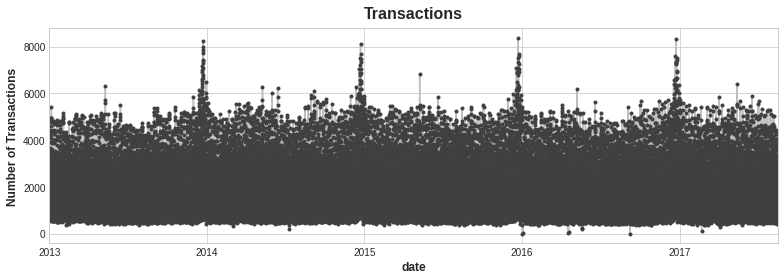

In [11]:
ax = transaction_sales.plot(**plot_params)
ax.set(title="Transactions", ylabel="Number of Transactions");

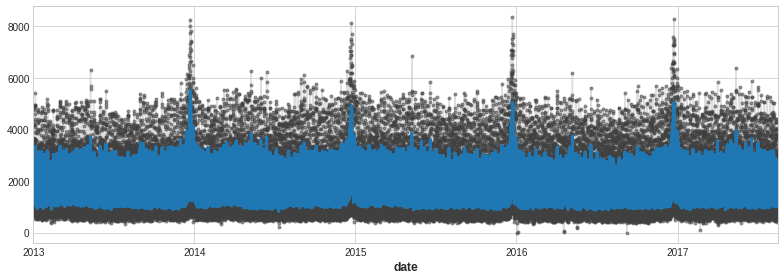

In [12]:
#Add methods to `transaction_sales` to compute a moving average with appropriate parameters for trend estimation.
trend = transaction_sales.rolling(
    window=12,
    center=True,
    min_periods=6,
).mean()

# Make a plot
ax = transaction_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

# **2) Identify trend**

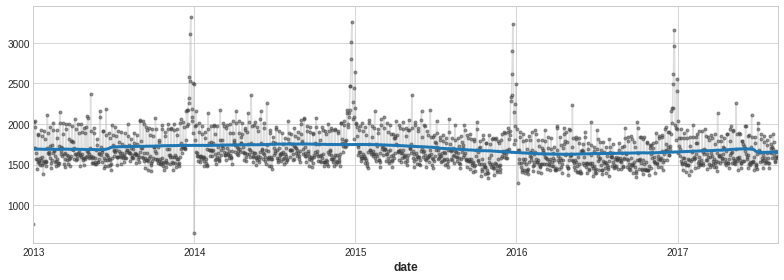

In [13]:
trend = average_transactions.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = average_transactions.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

# **3) Create a Trend Feature**

In [14]:
 from statsmodels.tsa.deterministic import DeterministicProcess

y = average_transactions.copy()  # the target

# Instantiate `DeterministicProcess` with arguments appropriate for a cubic trend model
dp = DeterministicProcess(index=y.index, order=3)

# Create the feature set for the dates given in y.index
X = dp.in_sample()

# Create features for a 90-day forecast.
X_fore = dp.out_of_sample(steps=90)

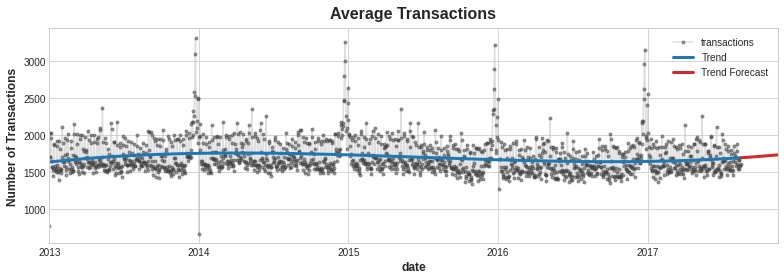

In [15]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Transactions", ylabel="Number of Transactions")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

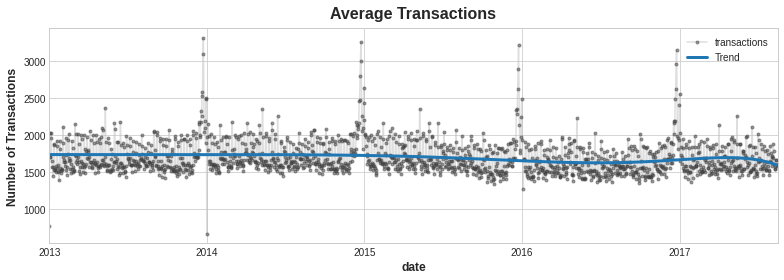

In [16]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(index=y.index, order=11) #Using an order 11 polynomial
X = dp.in_sample()

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Transactions", ylabel="Number of Transactions")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax.legend();

# **4) Understand risks of forecasting with high-order polynomials**

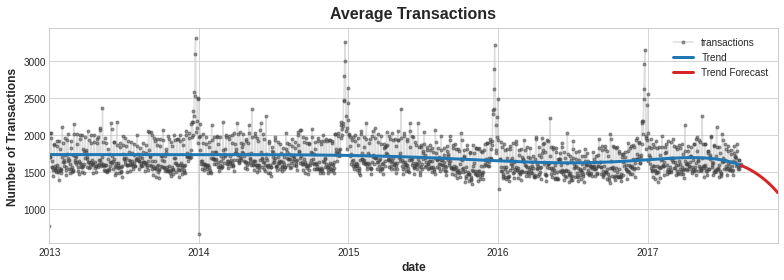

In [17]:
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Transactions", ylabel="Number of Transactions")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

# **Submission**

In [21]:
data_path =  "drive/My Drive/sample_submission.csv"
data = pd.read_csv(data_path)

pred_data = pd.DataFrame({'pred':y_pred}).reset_index()

output = pd.DataFrame({'id': data.id, 'sales': pred_data.pred})
output['sales'].fillna(float(output['sales'].mean()), inplace=True)

output.to_csv('submission.csv', index=False)